<a href="https://colab.research.google.com/github/AmitCosmo/hubble-data/blob/main/Viscous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install corner

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
# from numpy import *

In [3]:
x,y,yerr = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_31%20datas%20set.txt', unpack=True)

In [4]:
#Initial seeds
a1_ini = 4.6
b1_ini = 0.2
c1_ini = 0.1

#Define log-Likelihood Function

def likelihood(theta, x, y, yerr):
    a1, b1, c1 = theta
    model = 69 * ((((1 + x) ** ((3 - b1 - c1) / (2 - c1))) * (1 + (a1 / (b1 + c1 - 3)))) - (a1 / (b1 + c1 - 3)))
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))

In [5]:
#Define Prior Function
def prior(theta):
    try:
        a1, b1, c1 = theta
        if 0 < a1 < 10.0 and -10.0 < b1 < 10.0 and -10.0 < c1 < 10.0:
            return 0.0
    except ValueError:
        pass
    return -np.inf


#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))

In [6]:
#Define number of parameter, steps, burn-in phase
ndim=3
nsteps=300000
nburn_in=1000

initials=a1_ini,b1_ini,c1_ini

In [7]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1.2, 0.02, 0.03]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1])
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
a_result = np.zeros(nburn_in)
b_result = np.zeros(nburn_in)
samples_MH=np.array(result)
a1_mcmc, b1_mcmc, c1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" %
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

----------------------------------------------------------------------

Execution time with steps=300000------> 202.774 seconds
----------------------------------------------------------------------



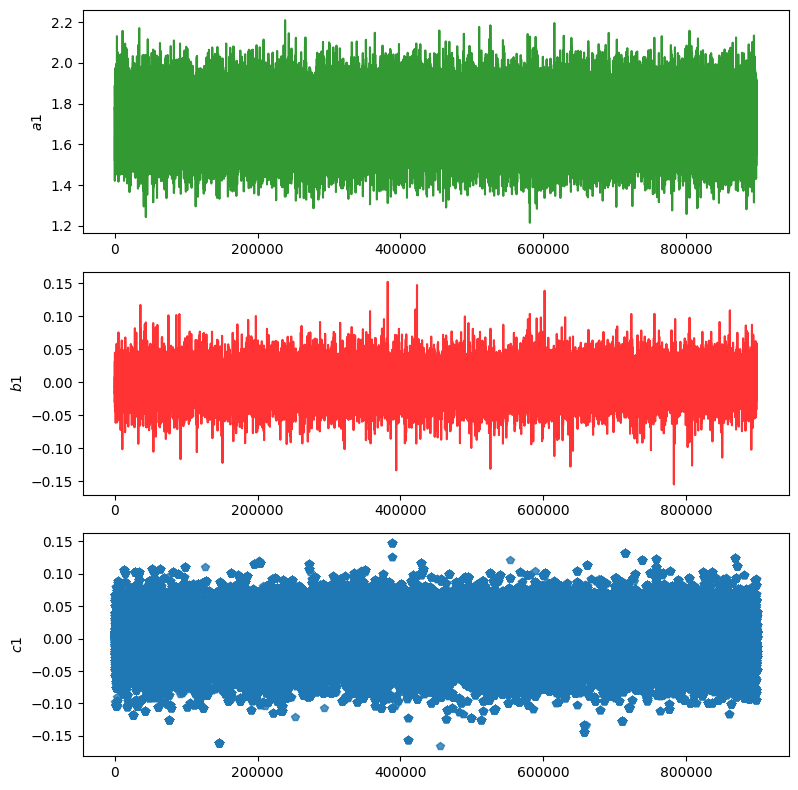

In [8]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of a
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$a1$")


# Plot the traceplot of b
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$b1$")

# Plot the traceplot of c
axes[2].plot(samples[2], "p", alpha=0.8)
axes[2].set_ylabel("$c1$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [9]:
print("""MCMC result:
    a1 = {0[0]} +{0[1]} -{0[2]}
    b1 = {2[0]} +{2[1]} -{2[2]}
    c1 = {4[0]} +{4[1]} -{4[2]}
""".format(a1_mcmc, a1_ini, b1_mcmc, b1_ini, c1_mcmc, c1_ini))

MCMC result:
    a1 = 1.713344462733162 +0.13313948002833076 -0.13303695136338223
    b1 = -0.00016076266118240316 +0.02097072862957404 -0.021673699534352664
    c1 = -0.00010283017440514379 +0.030635168391312893 -0.03024587568503109



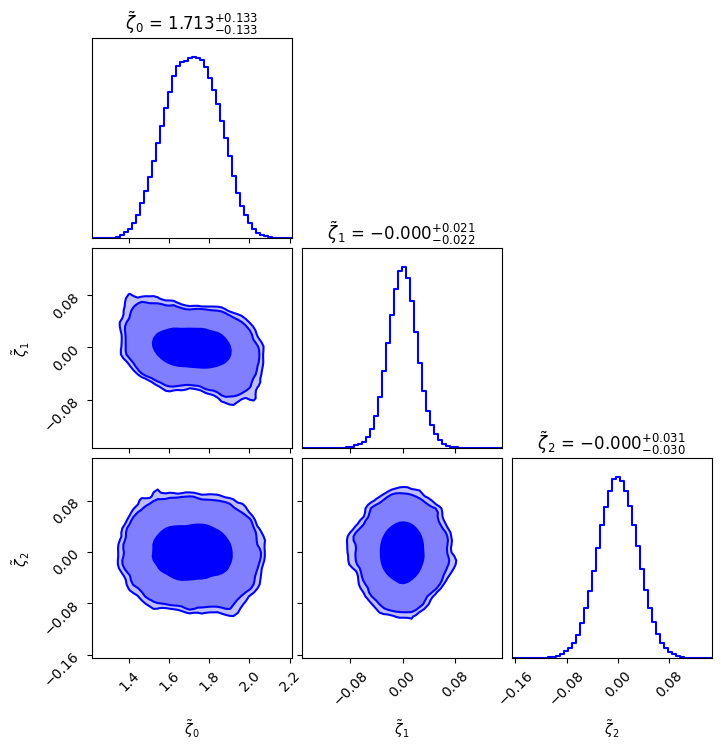

In [23]:
fig = corner.corner(samples_MH,bins=50,color="b",labels=["$\~\zeta_{0}$","$\~\zeta_{1}$","$\~\zeta_{2}$"],
                    fill_contours=True,
                    levels=(0.66,0.98,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)
#fig.savefig("FLCDM_H_46_MH.png")


In [ ]:
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_31%20datas%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Define the function to be fitted
def hubble_func(z, a1, b1, c1):
    return 69 * ((((1+z)** ((3-b1-c1)/(2-c1)))*(1+(a1/b1+c1-3)))-(a1/b1+c1-3))

# Create an lmfit Model object
model = Model(hubble_func)

# Set initial parameter values
params = model.make_params(a1=4.6, b1=-0.1, c1=-0.2)

# Perform the fit
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# Print the best-fit parameters
print("Best-fit Parameters:")
print("a1 =", best_fit_parameters['a1'].value)
print("b1 =", best_fit_parameters['b1'].value)
print("c1 =", best_fit_parameters['c1'].value)

Best-fit Parameters:
a1 = -830.47536290107
b1 = 29.631860395393986
c1 = 30.28093064166942


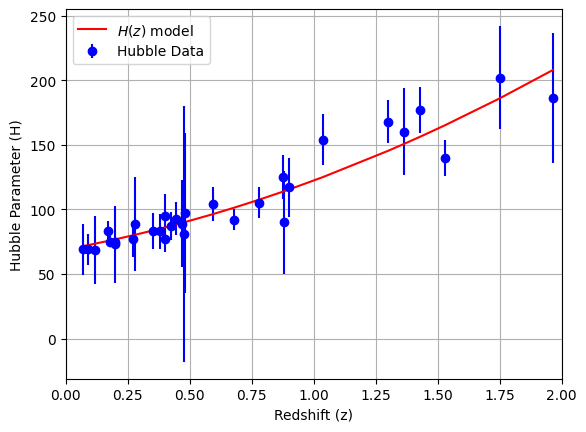

In [ ]:
# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='Hubble Data')

# Generate the predicted values from the best-fit parameters
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Add labels and legend
plt.xlim(0,2)
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)
plt.legend(loc="upper left")